<a href="https://colab.research.google.com/github/MuhammadShofiyyurrohman/machine-learning/blob/main/praktikum04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, RocCurveDisplay, ConfusionMatrixDisplay
)

MEMBACA DATA FILE CSV

In [47]:
df = pd.read_csv('/content/stunting_wasting_dataset.csv')
df.head()

,Jenis Kelamin,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting,Wasting
0,Laki-laki,19,91.6,13.3,Tall,Risk of Overweight
1,Laki-laki,20,77.7,8.5,Stunted,Underweight
2,Laki-laki,10,79.0,10.3,Normal,Risk of Overweight
3,Perempuan,2,50.3,8.3,Severely Stunted,Risk of Overweight
4,Perempuan,5,56.4,10.9,Severely Stunted,Risk of Overweight


MELIHAT INFORMASI UMUM DATASET

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Jenis Kelamin      100000 non-null  object 
 1   Umur (bulan)       100000 non-null  int64  
 2   Tinggi Badan (cm)  100000 non-null  float64
 3   Berat Badan (kg)   100000 non-null  float64
 4   Stunting           100000 non-null  object 
 5   Wasting            100000 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 4.6+ MB


CEK MISSING VALUE

In [49]:
# Cek missing value
df.isnull().sum()

,0
Jenis Kelamin,0
Umur (bulan),0
Tinggi Badan (cm),0
Berat Badan (kg),0
Stunting,0
Wasting,0


CEK NILAI UNIK

In [50]:
df['Stunting'].unique()

array(['Tall', 'Stunted', 'Normal', 'Severely Stunted'], dtype=object)

In [51]:
df['Jenis Kelamin'].unique()

array(['Laki-laki', 'Perempuan'], dtype=object)

MAPPING KOLOM KATEGORIK KE BENTUK NUMERIK

In [52]:
# 1. Mapping Kolom Stunting -> biner
map_stunt = {'Stunted' : 1, 'Severely Stunted': 1, 'Normal': 0, 'Tall': 0}
df['Stunting_bin'] = df['Stunting'].map(map_stunt).astype('Int64')

# 2. Mapping Kolom Jenis Kelamin -> biner
#    Laki-Laki = 1, Perempuan = 0
df['JK_bin'] = (df['Jenis Kelamin'] == 'Laki-Laki').astype(int)

print("Distribusi Stunting_bin:\n", df['Stunting_bin'].value_counts())
print("\nDistribusi JK_bin:\n", df['JK_bin'].value_counts())

Distribusi Stunting_bin:
 Stunting_bin
0    78021
1    21979
Name: count, dtype: Int64

Distribusi JK_bin:
 JK_bin
0    100000
Name: count, dtype: int64


ANALISIS KORELASI ANTAR VARIABEL NUMERIK

In [53]:
corr_matrix = df.corr(numeric_only=True)
corr_matrix

,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting_bin,JK_bin
Umur (bulan),1.000000,0.875869,0.665389,0.038630,NaN
Tinggi Badan (cm),0.875869,1.000000,0.626005,-0.283855,NaN
Berat Badan (kg),0.665389,0.626005,1.000000,0.021090,NaN
Stunting_bin,0.038630,-0.283855,0.021090,1.000000,NaN
JK_bin,NaN,NaN,NaN,NaN,NaN


VISUALISASI HEATMAP KORELASI

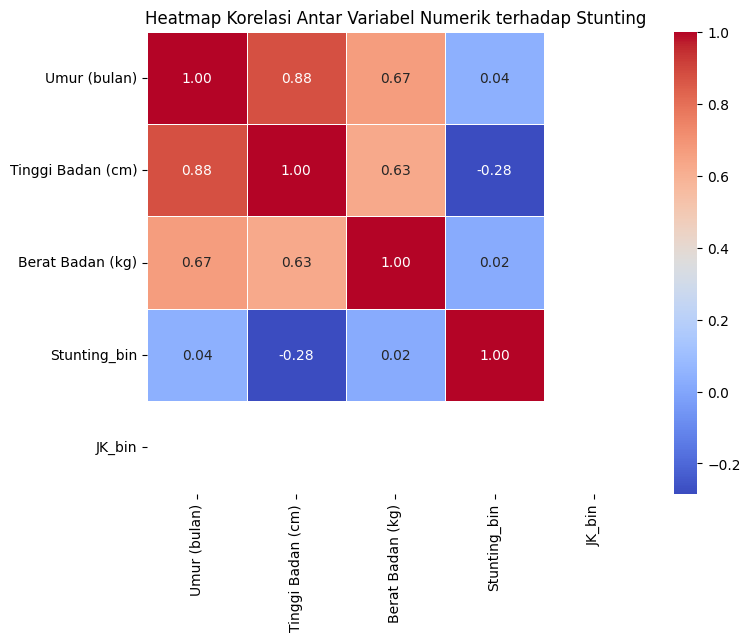

In [54]:
# Visualisasi heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Heatmap Korelasi Antar Variabel Numerik terhadap Stunting", fontsize=12)
plt.show()

MENENTUKAN FITUR DAN TARGET

In [55]:
# Fitur numerik dan gender
feature_num = ['Umur (bulan)', 'Tinggi Badan (cm)', 'Berat Badan (kg)']
feature_bin = ['JK_bin']

# Gabungkan & drop missing
use_cols = feature_num + feature_bin + ['Stunting_bin']
df_model = df[use_cols].dropna().copy()

X = df_model[feature_num + feature_bin]
y = df_model['Stunting_bin']

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (100000, 4)
y shape: (100000,)


MEMBAGI DATASET MENJADI TRAINING DAN TESTING SET

In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,
    random_state=42,
    stratify=y
)

print("Data latih:", X_train.shape)
print("Data uji:", X_test.shape)

Data latih: (80000, 4)
Data uji: (20000, 4)


PEMBANGUNAN MODEL LOGISTIC REGRESSION

In [59]:
# Scale hanya fitur numerik, gender langsung passthrough
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), feature_num),
        ('bin', 'passthrough', feature_bin),
    ],
    remainder='drop'
)

model = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    class_weight='balanced',
    random_state=42
)

clf = Pipeline([
    ('preprocess', preprocess),
    ('model', model)
])

# Latih model
clf.fit(X_train, y_train)
print("✅ Model Logistic Regression berhasil dilatih.")


✅ Model Logistic Regression berhasil dilatih.


PREDIKSI MODEL DAN EVALUASI MODEL

In [60]:
# Prediksi & probabilitas
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# Hitung metrik
print(f"Akurasi    : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision  : {precision_score(y_test, y_pred, zero_division=0):.4f}")
print(f"Recall     : {recall_score(y_test, y_pred, zero_division=0):.4f}")
print(f"F1-Score   : {f1_score(y_test, y_pred, zero_division=0):.4f}")
print(f"ROC-AUC    : {roc_auc_score(y_test, y_prob):.4f}")

# Contoh hasil keluaran:
# Akurasi    : 0.9055
# Precision  : 0.7152
# Recall     : 0.9472
# F1-Score   : 0.8150
# ROC-AUC    : 0.9656


Akurasi    : 0.8884
Precision  : 0.6814
Recall     : 0.9252
F1-Score   : 0.7848
ROC-AUC    : 0.9600


VISUALISASI HASIL EVALUASI

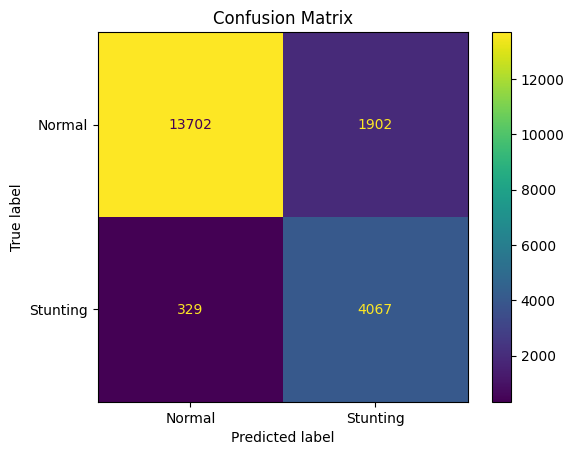

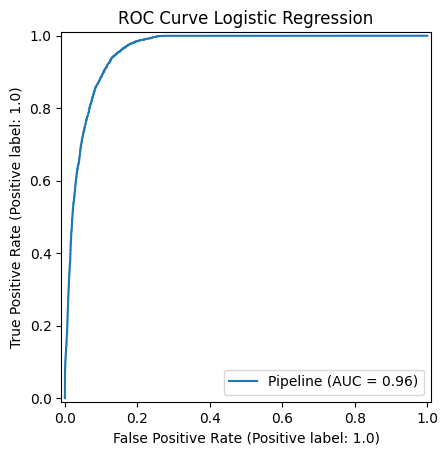

In [61]:
# Confusion Matrix
ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred),
    display_labels=['Normal', 'Stunting']
).plot(values_format='d')
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title("ROC Curve Logistic Regression")
plt.show()


CLASSIFICATION REPORT

In [62]:
from sklearn.metrics import classification_report

print(classification_report(
    y_test,
    y_pred,
    target_names=['Tidak Stunting (0)', 'Stunting (1)']
))


                    precision    recall  f1-score   support

Tidak Stunting (0)       0.98      0.88      0.92     15604
      Stunting (1)       0.68      0.93      0.78      4396

          accuracy                           0.89     20000
         macro avg       0.83      0.90      0.85     20000
      weighted avg       0.91      0.89      0.89     20000



CLASSIFICATION REPORT

In [63]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Lakukan cross validation (cv=5 berarti 5-fold)
scores = cross_val_score(clf, X, y, cv=5)

# Tampilkan hasil
print("Skor tiap fold:", scores)
print("Rata-rata akurasi:", np.mean(scores))
print("Standar deviasi:", np.std(scores))


Skor tiap fold: [0.88965 0.88335 0.88655 0.88185 0.8799 ]
Rata-rata akurasi: 0.88426
Standar deviasi: 0.0034624268945351072


INTERPRETASI MODEL LOGISTIC REGRESSION

In [64]:
# Ambil nama fitur & koefisien
feat_names = feature_num + feature_bin
coefs = clf.named_steps['model'].coef_[0]
odds = np.exp(coefs)

coef_df = pd.DataFrame({
    'Fitur': feat_names,
    'Koefisien (log-odds)': coefs,
    'Odds Ratio (e^coef)': odds
}).sort_values('Odds Ratio (e^coef)', ascending=False)

display(coef_df)


,Fitur,Koefisien (log-odds),Odds Ratio (e^coef)
0,Umur (bulan),7.319719,1509.779379
2,Berat Badan (kg),0.673071,1.960248
3,JK_bin,0.000000,1.000000
1,Tinggi Badan (cm),-9.088140,0.000113


PREDIKSI DATA BARU (contoh kasus)

In [65]:
# Contoh 2 anak
data_baru = pd.DataFrame({
    'Umur (bulan)': [24, 10],
    'Tinggi Badan (cm)': [79.0, 72.5],
    'Berat Badan (kg)': [9.2, 7.8],
    'JK_bin': [1, 0]  # 1 = Laki-Laki, 0 = Perempuan
})

pred = clf.predict(data_baru)
prob = clf.predict_proba(data_baru)[:, 1]

hasil = data_baru.copy()
hasil['prob_Stunting'] = prob
hasil['Pred (0=Tidak,1=Ya)'] = pred

display(hasil)


,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),JK_bin,prob_Stunting,"Pred (0=Tidak,1=Ya)"
0,24,79.0,9.2,1,0.991894,1.0
1,10,72.5,7.8,0,0.011019,0.0
